In [1]:
# Task for the 15th of December, 2017



# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

import gempy as gp
%matplotlib inline

import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Weighted gravity example

In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'serif',
              'transition': 'slide',
              'start_slideshow_at': 'selected',
              'scroll': True,
})

{'scroll': True,
 'start_slideshow_at': 'selected',
 'theme': 'serif',
 'transition': 'slide'}

In [3]:
# Load data, define resolution 
# Note: resolution (res) and domain boundaries are defined beforehand now as variables as they are needed for 
# various causes later as well (like computing the centroids)
res = 20
xdown = -10; xup = 30; ydown = -10; yup = 20; zdown = -10; zup = 0

geo_data = gp.create_data([xdown,xup,ydown,yup,zdown,zup],[res, res, res],
                         path_f = "paper_Foliations.csv",
                         path_i = "paper_Points.csv")
geo_data.add_interface(X=10, Y=4, Z=-7, formation='fault1')

geo_data.interfaces.set_value(geo_data.interfaces['formation'] == 'Layer1', 'Z_std', 2)
geo_data.interfaces.set_value(geo_data.interfaces['formation'] == 'Layer2', 'Z_std', 2)


../../gempy/data_management.py:61: UserWarning: path_f is deprecated use instead path_o
  warnings.warn('path_f is deprecated use instead path_o')


,X,Y,Z,formation,series,order_series,isFault,formation number,annotations,Z_std
0,4.345153,5.0,-1.921564,fault1,Default serie,1,False,1,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",NaN
1,10.000000,4.0,-7.000000,fault1,Default serie,1,False,1,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",NaN
2,2.303022,5.0,-1.647248,Unconformity,Default serie,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},0}$",NaN
3,1.083840,5.0,-1.738687,Unconformity,Default serie,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},1}$",NaN
4,8.825648,5.0,-3.140747,Unconformity,Default serie,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},2}$",NaN
5,15.561631,5.0,-3.232185,Unconformity,Default serie,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},3}$",NaN
6,2.211584,5.0,-5.518153,Layer1,Default serie,1,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},0}$",2.0
7,11.172574,5.0,-6.981171,Layer1,Default serie,1,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},1}$",2.0
8,15.104438,5.0,-8.108915,Layer1,Default serie,1,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},2}$",2.0
9,2.059186,5.0,-4.908561,Layer2,Default serie,1,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},0}$",2.0


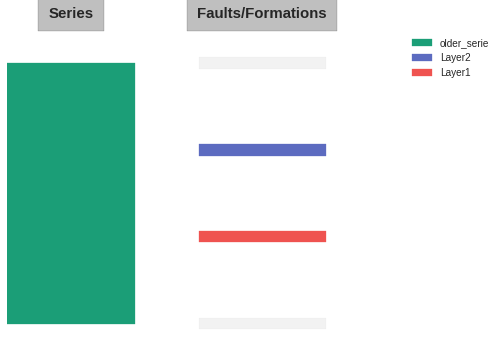

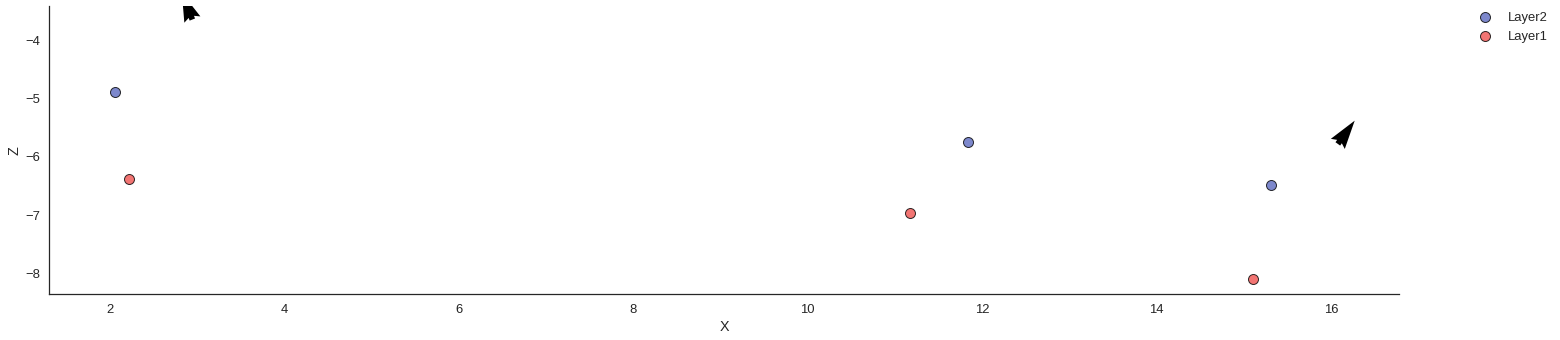

In [4]:
gp.set_series(geo_data, {'fault_serie1': 'fault1','younger_serie' : 'Unconformity', 'older_serie': ('Layer1', 'Layer2')},
              order_formations= ['fault1', 'Unconformity', 'Layer2', 'Layer1'], verbose=0)

geo_data.modify_interface(9, Z = -6.4)

geo_data = gp.select_series(geo_data, ['older_serie'])
gp.get_sequential_pile(geo_data)

gp.plot_data(geo_data)

In [14]:
# Here in verbose is set density block to see that some of the voxels have the density changed
# When making this stochastic it is better to delete it to avoid many prints
interp_data_grav = gp.InterpolatorData(geo_data, u_grade=[1], dtype='float32', verbose=['density_block'], output='gravity')

In [15]:
# After compoling we need to set so
gp.set_geophysics_obj(interp_data_grav,  [0.1,19.9,.1,.9, -10, 0], # Extent
                                             [1,1], ) # Resoluion of the measurement

In [16]:
# Now we compute the distances and the component z from the points where we want to compute gravity (in this case just 1 pixel)
# To all the voxels within a range
# This function also works to change the values of each rock type to densities
gp.precomputations_gravity(interp_data_grav, 1, [2.92, 3.1, 2.61]); 

### here starts the code for the weighted gravity

In [17]:
# First we compile the theano function as ususal
interp_data_grav.th_fn = interp_data_grav.compile_th_fn(output='gravity')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


#### Form here...

In [9]:
# We read the pandas dataframe with the % made in the other notebook

# Usually this has to be recomputed at every iteration
import pandas as pn
weigths_df = pn.read_pickle("weights.pickle")

In [10]:
np.ones((0))

array([], dtype=float64)

In [11]:
# Now we need to set the indecies of voxels that are gray
interp_data_grav.interpolator.tg.weigths_index.set_value(weigths_df.index.values)

# And for those indeces the weighted density
interp_data_grav.interpolator.tg.weigths_weigths.set_value((weigths_df *  [2.92, 3.1, 2.61] ).values.sum(axis=1))

In [17]:
# This cell is in case you want to see the case of no-gray voxels for comparison

if False:
    interp_data_grav.interpolator.tg.weigths_index.set_value([])
    interp_data_grav.interpolator.tg.weigths_weigths.set_value([])

In [18]:
# Now we compute
lith, _, g = gp.compute_model(interp_data_grav, output='gravity')

density block __str__ = [ 2.6099999   2.92000008  2.92000008 ...,  3.0999999   3.0999999   3.0999999 ]


#### ...to here, is what you need to add to the pymc2 code

In [16]:
# Using gray voxels
g

array([ 21.91448021], dtype=float32)

In [19]:
# Using normal voxels
g

array([ 21.89094734], dtype=float32)